# Notebook 025: KNN Models using final predictor set

This notebook contains a KNN crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'

The baseline models tested are Multi-class KNN Models with and without regularization.

In [49]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed\X_train.csv
	../data/raw\shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

## Read labeled training and TEST data and subset predictors and response variable

In [4]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [5]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [6]:
# summarize dataframe info
print('Y TRAIN DATA WITH ADDITIONAL LABELS\n')
y_train_labels.info()
print('\n\nX TRAIN DATA WITH ADDITIONAL LABELS\n')
X_train_labels.info()
print('\n\nX TRAIN PREDICTORS (WITH LABEL COLUMNS EXCLUDED)\n')
print(predictor_columns)
print('\n\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY\n')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\n\nX SCALER DATA INFO\n')
X_scaler.info()
print(
    '\n\nTHE X SCALER DATA CONTAINS MEANS AND STDS FOR THE FOLLOWING STANDARDIZED '\
    '(i.e. SCALED) PREDICTORS\n\n{}'.format(X_scaler['scaled-feature'].values)
)

Y TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 4 columns):
crime-type             128352 non-null int64
crime-type-cat         128352 non-null object
OFFENSE_DESCRIPTION    128352 non-null object
INCIDENT_NUMBER        128352 non-null object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


X TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 60 columns):
date                                 128352 non-null object
year                                 128352 non-null int64
month                                128352 non-null int64
hour                                 128352 non-null int64
time                                 128352 non-null int64
ZIP5                                 128352 non-null int64
ZIP5_area                            128352 non-null float64
Name                                 128352 non-null o

In [7]:
# create lists of predictors based on numeric type for easier treatment of specific types
predictors_binary = [
    'night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
    'college-near', 'highschool-near'
]
predictors_nonbinary = [col for col in X_train.columns if col not in predictors_binary]
predictors_discrete = [
    'streetlights-night',
    'median-age',
]
predictors_continuous = [col for col in predictors_nonbinary if col not in predictors_discrete]

print(
    'Binary predictors in the X training data are:\n\n{}\n\n\n'\
    'Non-binary predictors are:\n\n{}\n\n\n'\
    'Of the non-binary, the following are discrete:\n\n{}\n\n\n'\
    'And these remaining are continuous:\n\n{}\n'.format(
        predictors_binary,
        predictors_nonbinary,
        predictors_discrete,
        predictors_continuous
    )
)

Binary predictors in the X training data are:

['night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'college-near', 'highschool-near']


Non-binary predictors are:

['streetlights-night', 'lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-age', 'median-income', 'poverty-rate', 'less-than-high-school-perc', 'bachelor-degree-or-more-perc', 'enrolled-college-perc', 'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'commercial-mix-ratio-3yr-cagr', 'industrial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-gini-coef-3yr-cagr', 'residential-median-value-3yr-cagr']


Of the non-binary, the following are discrete:

['streetlights-night', 'median-age']


And these remaining are continuous:

['lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-income', 'poverty-rate', 'less

## Create value count summary tables by crime-type for later reference

In [8]:
agg_dict = {'INCIDENT_NUMBER': 'count'}

crime_types_train = y_train_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_train['proportion'] = crime_types_train / crime_types_train.sum()

crime_types_test = y_test_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_test['proportion'] = crime_types_test / crime_types_test.sum()

In [9]:
print(
    'The number of observed crime type classes in both the training and test set are:\n\n'\
    'TRAINING\n{}\n\n\nTEST\n{}\n'.format(
        crime_types_train,
        crime_types_test
    )
)

The number of observed crime type classes in both the training and test set are:

TRAINING
                                   count  proportion
crime-type crime-type-cat                           
0          other                    6321    0.049247
1          burglary                 5664    0.044129
2          drugs-substances        13082    0.101923
3          fraud                    9587    0.074693
4          harassment-disturbance  20767    0.161797
5          robbery                  3423    0.026669
6          theft                   34555    0.269221
7          vandalism-property      13710    0.106816
8          violence-aggression     21243    0.165506


TEST
                                   count  proportion
crime-type crime-type-cat                           
0          other                    1580    0.049240
1          burglary                 1416    0.044129
2          drugs-substances         3271    0.101938
3          fraud                    2397    0.074701
4

### Copy original data and create a small random sample of the data to speed up model tuning

In [10]:
# copy original data before sampling
X_train_orig = X_train.copy()
X_train_scaled_orig = X_train_scaled.copy()
y_train_orig = y_train.copy()

X_test_orig = X_test.copy()
X_test_scaled_orig = X_test_scaled.copy()
y_test_orig = y_test.copy()

In [11]:
# take a random sample of the data
data_fraction = 0.1
random_val = 709

X_train = X_train.sample(frac=data_fraction, random_state=random_val)
X_train_scaled = X_train_scaled.sample(frac=data_fraction, random_state=random_val)
y_train = y_train_labels[response_column].sample(frac=data_fraction, random_state=random_val)  #y_train_labels is dataframe
y_train = y_train.values.ravel()

X_test = X_test.sample(frac=data_fraction, random_state=random_val)
X_test_scaled = X_test_scaled.sample(frac=data_fraction, random_state=random_val)
y_test = y_test_labels[response_column].sample(frac=data_fraction, random_state=random_val)  #y_test_labels is dataframe
y_test = y_test.values.ravel()

# confirm shape of new dataframes
print('\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\nTHE SHAPE OF THE X AND Y TEST FRAMES WITH PREDICTORS ONLY')
print(X_test.shape)
print(X_test_scaled.shape)
print(y_test.shape)


THE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY
(12835, 43)
(12835, 43)
(12835,)

THE SHAPE OF THE X AND Y TEST FRAMES WITH PREDICTORS ONLY
(3209, 43)
(3209, 43)
(3209,)


## MODEL 1: Default parameters for the KNN Classifier

In [12]:
KNNModels_1 = {}  # dictionary for KNN models

k_values = [3,5,9,13,17,21,23,25,27,29,31,37,55,85,145,205]  # values of k we want to run models for

# run KNN for each value of k in k_values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    KNNModels_1[k] = knn

KNNModels_1

{3: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                      weights='uniform'),
 5: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                      weights='uniform'),
 9: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                      weights='uniform'),
 13: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                      weights='uniform'),
 17: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=17, p=2,
                      weights='uniform'),
 21: KNeighborsClassifier(algorithm=

In [13]:
%%time

r2_train_scores_1 = [] # R2 scores

for k, model in KNNModels_1.items():  # use the pre-trained models stored in the KNNModels dictionary
    r2 = model.score(X_train_scaled, y_train) 
    r2_train_scores_1.append(r2)

display(r2_train_scores_1)

[0.5206077132839891,
 0.4637319828593689,
 0.40389559797428903,
 0.37919750681729647,
 0.3657966497857421,
 0.353019088430074,
 0.3495130502532139,
 0.34242306194000777,
 0.3421114141020647,
 0.33852746396571876,
 0.33354109855862873,
 0.3302687962602259,
 0.3206856252434749,
 0.3095442150370082,
 0.3037008180755746,
 0.30151928320997273]

Wall time: 1min 13s


In [14]:
%%time

r2_test_scores_1 = [] # R2 scores

for k, model in KNNModels_1.items():  # use the pre-trained models stored in the KNNModels dictionary
    r2 = model.score(X_test_scaled, y_test) 
    r2_test_scores_1.append(r2)

display(r2_test_scores_1)

[0.19725771268307885,
 0.2343409161732627,
 0.25677781240261766,
 0.2729822374571518,
 0.282330944219383,
 0.29136802742287315,
 0.29230289809909626,
 0.2963540043627298,
 0.2938610158928015,
 0.297600498597694,
 0.29604238080398876,
 0.29884699283265814,
 0.2991586163913992,
 0.30663758180118417,
 0.3172327827983796,
 0.3153630414459333]

Wall time: 23 s


In [15]:
# combine multiple lists into dataframe (https://stackoverflow.com/questions/30522724)
df_r2_1 = pd.DataFrame({'KNN':k_values, 'Train_R2':r2_train_scores_1, 'Test_R2':r2_test_scores_1})

display(df_r2_1)

,KNN,Train_R2,Test_R2
0,3,0.520608,0.197258
1,5,0.463732,0.234341
2,9,0.403896,0.256778
3,13,0.379198,0.272982
4,17,0.365797,0.282331
5,21,0.353019,0.291368
6,23,0.349513,0.292303
7,25,0.342423,0.296354
8,27,0.342111,0.293861
9,29,0.338527,0.297600


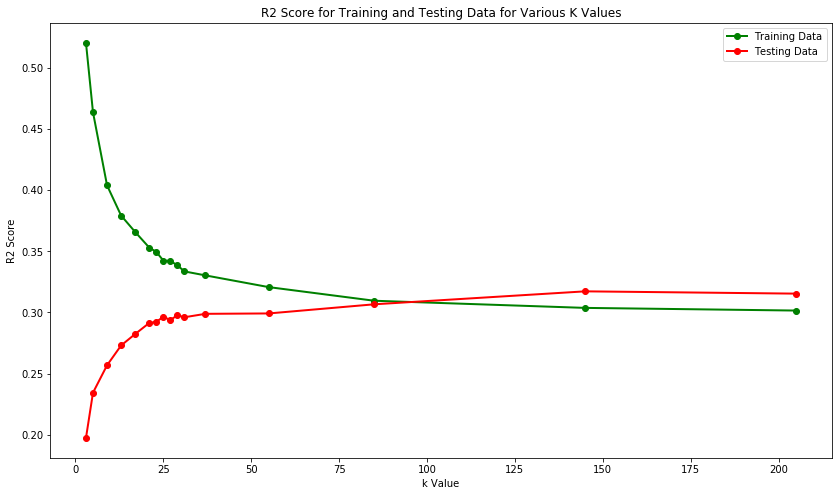

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.plot(df_r2_1['KNN'], df_r2_1['Train_R2'], label='Training Data', linewidth=2, marker='o', color='green')
ax.plot(df_r2_1['KNN'], df_r2_1['Test_R2'], label='Testing Data', linewidth=2, marker='o', color='red')

ax.set_xlabel('k Value')
ax.set_ylabel('R2 Score')
ax.set_title('R2 Score for Training and Testing Data for Various K Values')

ax.legend()
plt.show()

## MODEL 2: KNN Classifier (manhattan distance)

In [17]:
KNNModels_2 = {}  # dictionary for KNN models

k_values = [3,5,9,13,17,21,23,25,27,29,31,37,55,85,145,205]  # values of k we want to run models for

# run KNN for each value of k in k_values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=1, n_jobs=-1)  #p=1 manhattan distance is 0.02 better
    knn.fit(X_train_scaled, y_train)
    KNNModels_2[k] = knn

KNNModels_2

{3: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
                      weights='uniform'),
 5: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
                      weights='uniform'),
 9: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=9, p=1,
                      weights='uniform'),
 13: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=13, p=1,
                      weights='uniform'),
 17: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=17, p=1,
                      weights='uniform'),
 21: KNeighborsClassifier(algorithm=

In [18]:
%%time

r2_train_scores_2 = [] # R2 scores

for k, model in KNNModels_2.items():  # use the pre-trained models stored in the KNNModels dictionary
    r2 = model.score(X_train_scaled, y_train) 
    r2_train_scores_2.append(r2)

display(r2_train_scores_2)

[0.5213089209193611,
 0.46848461238800154,
 0.4054538371640047,
 0.38044409816906893,
 0.36813400857031553,
 0.3599532528243085,
 0.3547331515387612,
 0.35294117647058826,
 0.3520841449162446,
 0.3474094273470978,
 0.3457732761978964,
 0.3414102064666926,
 0.32621737436696535,
 0.31546552395792754,
 0.3012855473315154,
 0.3019088430074016]

Wall time: 1min 18s


In [19]:
%%time

r2_test_scores_2 = [] # R2 scores

for k, model in KNNModels_2.items():  # use the pre-trained models stored in the KNNModels dictionary
    r2 = model.score(X_test_scaled, y_test) 
    r2_test_scores_2.append(r2)

display(r2_test_scores_2)

[0.20722966656279215,
 0.24181988158304768,
 0.2645684013711437,
 0.28887503895294486,
 0.2985353692739171,
 0.2966656279214709,
 0.29822374571517607,
 0.3032097226550327,
 0.3078840760361483,
 0.305079464007479,
 0.3088189467123715,
 0.3038329697725148,
 0.31100031162355873,
 0.3159862885634154,
 0.3134933000934871,
 0.31505141788719226]

Wall time: 22.3 s


In [20]:
# combine multiple lists into dataframe (https://stackoverflow.com/questions/30522724)
df_r2_2 = pd.DataFrame({'KNN':k_values, 'Train_R2':r2_train_scores_2, 'Test_R2':r2_test_scores_2})

display(df_r2_2)

,KNN,Train_R2,Test_R2
0,3,0.521309,0.207230
1,5,0.468485,0.241820
2,9,0.405454,0.264568
3,13,0.380444,0.288875
4,17,0.368134,0.298535
5,21,0.359953,0.296666
6,23,0.354733,0.298224
7,25,0.352941,0.303210
8,27,0.352084,0.307884
9,29,0.347409,0.305079


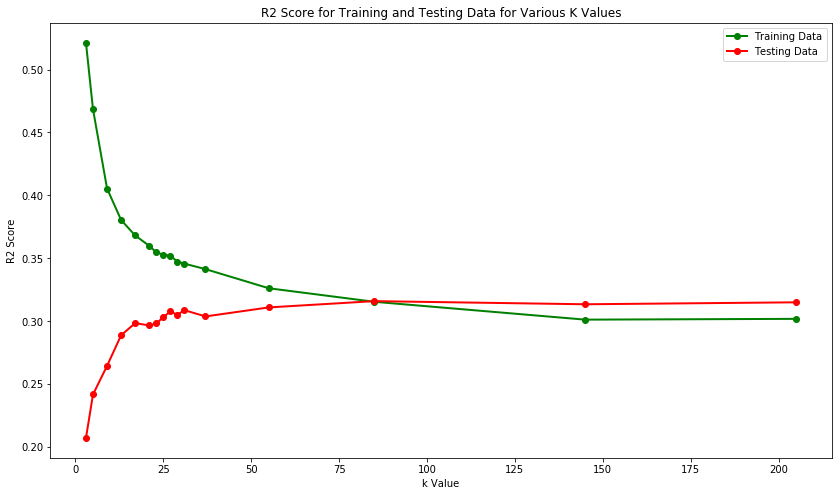

In [21]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.plot(df_r2_2['KNN'], df_r2_2['Train_R2'], label='Training Data', linewidth=2, marker='o', color='green')
ax.plot(df_r2_2['KNN'], df_r2_2['Test_R2'], label='Testing Data', linewidth=2, marker='o', color='red')

ax.set_xlabel('k Value')
ax.set_ylabel('R2 Score')
ax.set_title('R2 Score for Training and Testing Data for Various K Values')

ax.legend()
plt.show()

## MODEL 3: KNN Classifier (manhattan distance and distance weights)

In [22]:
KNNModels_3 = {}  # dictionary for KNN models

k_values = [3,5,9,13,17,21,23,25,27,29,31,37,55,85,145,205]  # values of k we want to run models for

# run KNN for each value of k in k_values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=1, n_jobs=-1)  #p=1 manhattan distance is 0.02 better
    knn.fit(X_train_scaled, y_train)
    KNNModels_3[k] = knn

KNNModels_3

{3: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
                      weights='distance'),
 5: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
                      weights='distance'),
 9: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=9, p=1,
                      weights='distance'),
 13: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=13, p=1,
                      weights='distance'),
 17: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=17, p=1,
                      weights='distance'),
 21: KNeighborsClassifier(algor

In [23]:
%%time

r2_train_scores_3 = [] # R2 scores

for k, model in KNNModels_3.items():  # use the pre-trained models stored in the KNNModels dictionary
    r2 = model.score(X_train_scaled, y_train) 
    r2_train_scores_3.append(r2)

display(r2_train_scores_3)

[0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109,
 0.993922867160109]

Wall time: 1min 21s


In [24]:
%%time

r2_test_scores_3 = [] # R2 scores

for k, model in KNNModels_3.items():  # use the pre-trained models stored in the KNNModels dictionary
    r2 = model.score(X_test_scaled, y_test) 
    r2_test_scores_3.append(r2)

display(r2_test_scores_3)

[0.22249922094110314,
 0.2411966344655656,
 0.26893113119351825,
 0.2860704269242755,
 0.29354939233406047,
 0.2957307572452477,
 0.29978186350888125,
 0.3004051106263634,
 0.3060143346837021,
 0.3038329697725148,
 0.30726082891866624,
 0.31193518229978184,
 0.3100654409473356,
 0.31131193518229977,
 0.31567466500467434,
 0.3172327827983796]

Wall time: 19.7 s


In [25]:
# combine multiple lists into dataframe (https://stackoverflow.com/questions/30522724)
df_r2_3 = pd.DataFrame({'KNN':k_values, 'Train_R2':r2_train_scores_3, 'Test_R2':r2_test_scores_3})

display(df_r2_3)

,KNN,Train_R2,Test_R2
0,3,0.993923,0.222499
1,5,0.993923,0.241197
2,9,0.993923,0.268931
3,13,0.993923,0.286070
4,17,0.993923,0.293549
5,21,0.993923,0.295731
6,23,0.993923,0.299782
7,25,0.993923,0.300405
8,27,0.993923,0.306014
9,29,0.993923,0.303833


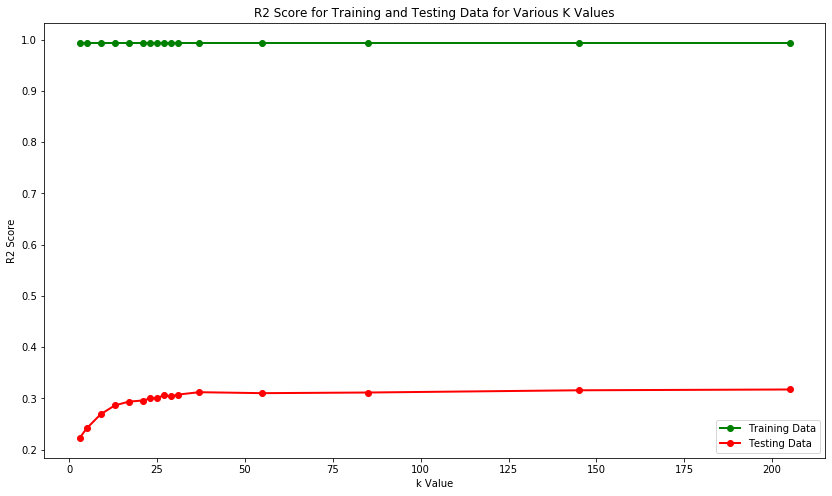

In [26]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.plot(df_r2_3['KNN'], df_r2_3['Train_R2'], label='Training Data', linewidth=2, marker='o', color='green')
ax.plot(df_r2_3['KNN'], df_r2_3['Test_R2'], label='Testing Data', linewidth=2, marker='o', color='red')

ax.set_xlabel('k Value')
ax.set_ylabel('R2 Score')
ax.set_title('R2 Score for Training and Testing Data for Various K Values')

ax.legend()
plt.show()

### Restore original data and run tuned model on full data

In [27]:
# Restore back to original dataframes once model working as expected
X_train = X_train_orig
X_train_scaled = X_train_scaled_orig
y_train = y_train_orig

X_test = X_test_orig
X_test_scaled = X_test_scaled_orig
y_test = y_test_orig

# confirm shape of new dataframes
print('\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\nTHE SHAPE OF THE X AND Y TEST FRAMES WITH PREDICTORS ONLY')
print(X_test.shape)
print(X_test_scaled.shape)
print(y_test.shape)


THE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY
(128352, 43)
(128352, 43)
(128352,)

THE SHAPE OF THE X AND Y TEST FRAMES WITH PREDICTORS ONLY
(32088, 43)
(32088, 43)
(32088,)


## Use Insights from Sampled Data on Full Data

In [33]:
KNNModels = {}  # dictionary for KNN models

k_values = [3,9,15,23,35,53,75,97,135,205,405,605]  # values of k we want to run models for

# run KNN for each value of k in k_values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=1, n_jobs=-1)  #p=1 manhattan distance is 0.02 better
    knn.fit(X_train_scaled, y_train)
    KNNModels[k] = knn

KNNModels

{3: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
                      weights='distance'),
 9: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=9, p=1,
                      weights='distance'),
 15: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=15, p=1,
                      weights='distance'),
 23: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=23, p=1,
                      weights='distance'),
 35: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=35, p=1,
                      weights='distance'),
 53: KNeighborsClassifier(alg

In [34]:
%%time

r2_test_scores = [] # R2 scores

for k, model in KNNModels.items():  # use the pre-trained models stored in the KNNModels dictionary
    r2 = model.score(X_test_scaled, y_test) 
    r2_test_scores.append(r2)

display(r2_test_scores)

[0.27455746696584393,
 0.2988967838444278,
 0.30924333084018946,
 0.3166915981052107,
 0.3230491149339317,
 0.3271316379955123,
 0.3335514834205934,
 0.33797681376215405,
 0.3410620792819746,
 0.3459548740962354,
 0.35019321864871605,
 0.3519695836449763]

Wall time: 15min 30s


In [35]:
# combine multiple lists into dataframe (https://stackoverflow.com/questions/30522724)
df_r2 = pd.DataFrame({'KNN':k_values, 'Test_R2':r2_test_scores})

display(df_r2)

,KNN,Test_R2
0,3,0.274557
1,9,0.298897
2,15,0.309243
3,23,0.316692
4,35,0.323049
5,53,0.327132
6,75,0.333551
7,97,0.337977
8,135,0.341062
9,205,0.345955


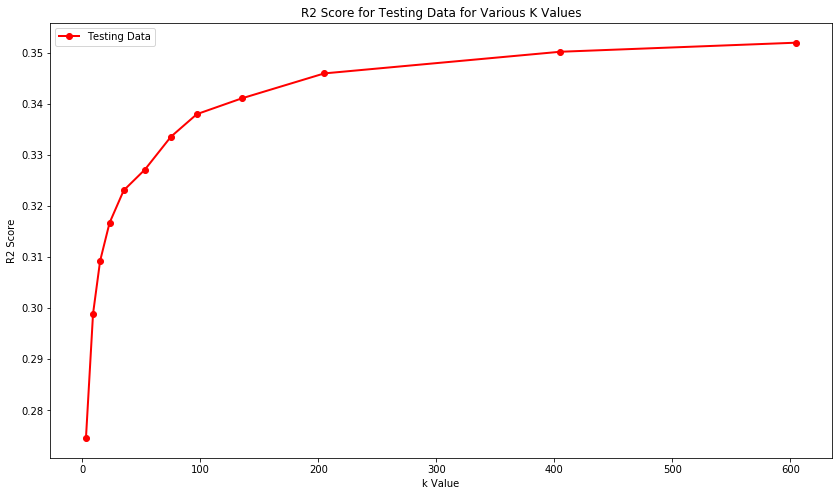

In [36]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.plot(df_r2['KNN'], df_r2['Test_R2'], label='Testing Data', linewidth=2, marker='o', color='red')

ax.set_xlabel('k Value')
ax.set_ylabel('R2 Score')
ax.set_title('R2 Score for Testing Data for Various K Values')

ax.legend()
plt.show()

**The curve flattens out as k increases with an asymptote around 0.355.  The elbow of the curve is around a k value of 100.  And the curve really flattens out beyond a k value of around 200.**

**To maximize predictability we will use a k value of 205 below.**

## Score and Confusion Matrix for Selected Model

In [38]:
knn = KNeighborsClassifier(n_neighbors=205, weights='distance', p=1, n_jobs=-1)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=205, p=1,
                     weights='distance')

In [40]:
%%time

knn_predictions = knn.predict(X_test_scaled)

Wall time: 2min 7s


In [46]:
# roc_auc_score(y_test, knn_predictions)  # does not support multiclass formats

# copied directly from (https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
        
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
        
    return roc_auc_score(y_test, y_pred, average=average)

In [48]:
print('KNN Model AUC Score (Testing):', multiclass_roc_auc_score(y_test, knn_predictions))

KNN Model AUC Score (Testing): 0.574517118846288


In [51]:
print('Confusion Matrix for KNN with k = 205 (Testing):\n')
print(confusion_matrix(y_test, knn_predictions))

Confusion Matrix for KNN with k = 205 (Testing):

[[ 279    8  162   20  272   13  583   25  218]
 [  11  100   80    8  339    3  715   55  105]
 [ 136   11 1757   25  375    7  730   34  196]
 [  28    9  128  112  500    8 1407   27  178]
 [  82   28  261   42 2239   12 1672  144  712]
 [  23    2   60    4  158   34  360   20  195]
 [  79   99  501  163 1346   46 5484  281  640]
 [  41   61  200   18  938   11 1575  152  431]
 [ 180   29  375   37 1469  140 1943  193  944]]


**KNN does not allow for the determination of feature importance but we'll used linear/logistic regression and decision trees to derive importances.**